In [ ]:
import numpy as np
import os
from dataset import ImageDataset
from torch.utils.data import DataLoader
import torch
from vit_pytorch import ViT
from vit_pytorch.cct import CCT
from scripts.model import *
from vit_pytorch.recorder import Recorder
from vit_pytorch.extractor import Extractor
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [13]:
img_dir = 'linsen_data'
annotations_file = 'linsen_data/annotations.csv'

BATCH_SIZE = 32
num_epochs = 8

ds_train = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='train')
ds_test = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, set_type='test')
  
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
image_size = 128
patch_size = 32
num_classes = 2
dim = 4
depth = 4
heads = 4
mlp_dim = 128
dropout = 0.01
emb_dropout = 0.01
 
model_config = {
  'image_size' : image_size,
  'patch_size' : patch_size,
  'num_classes' : num_classes,
  'dim' : dim,
  'depth' : depth,
  'heads' : heads,
  'mlp_dim' : mlp_dim,
  'dropout' : dropout,
  'emb_dropout' : emb_dropout
  }
 
model = ViT(image_size = image_size,
            patch_size = patch_size,
            num_classes = num_classes,
            dim = dim,
            depth = depth,
            heads = heads,
            mlp_dim = mlp_dim,
            dropout = dropout,
            emb_dropout = emb_dropout)

model.load_state_dict(torch.load('models/vit/model.pth', weights_only=True))
        
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

39622


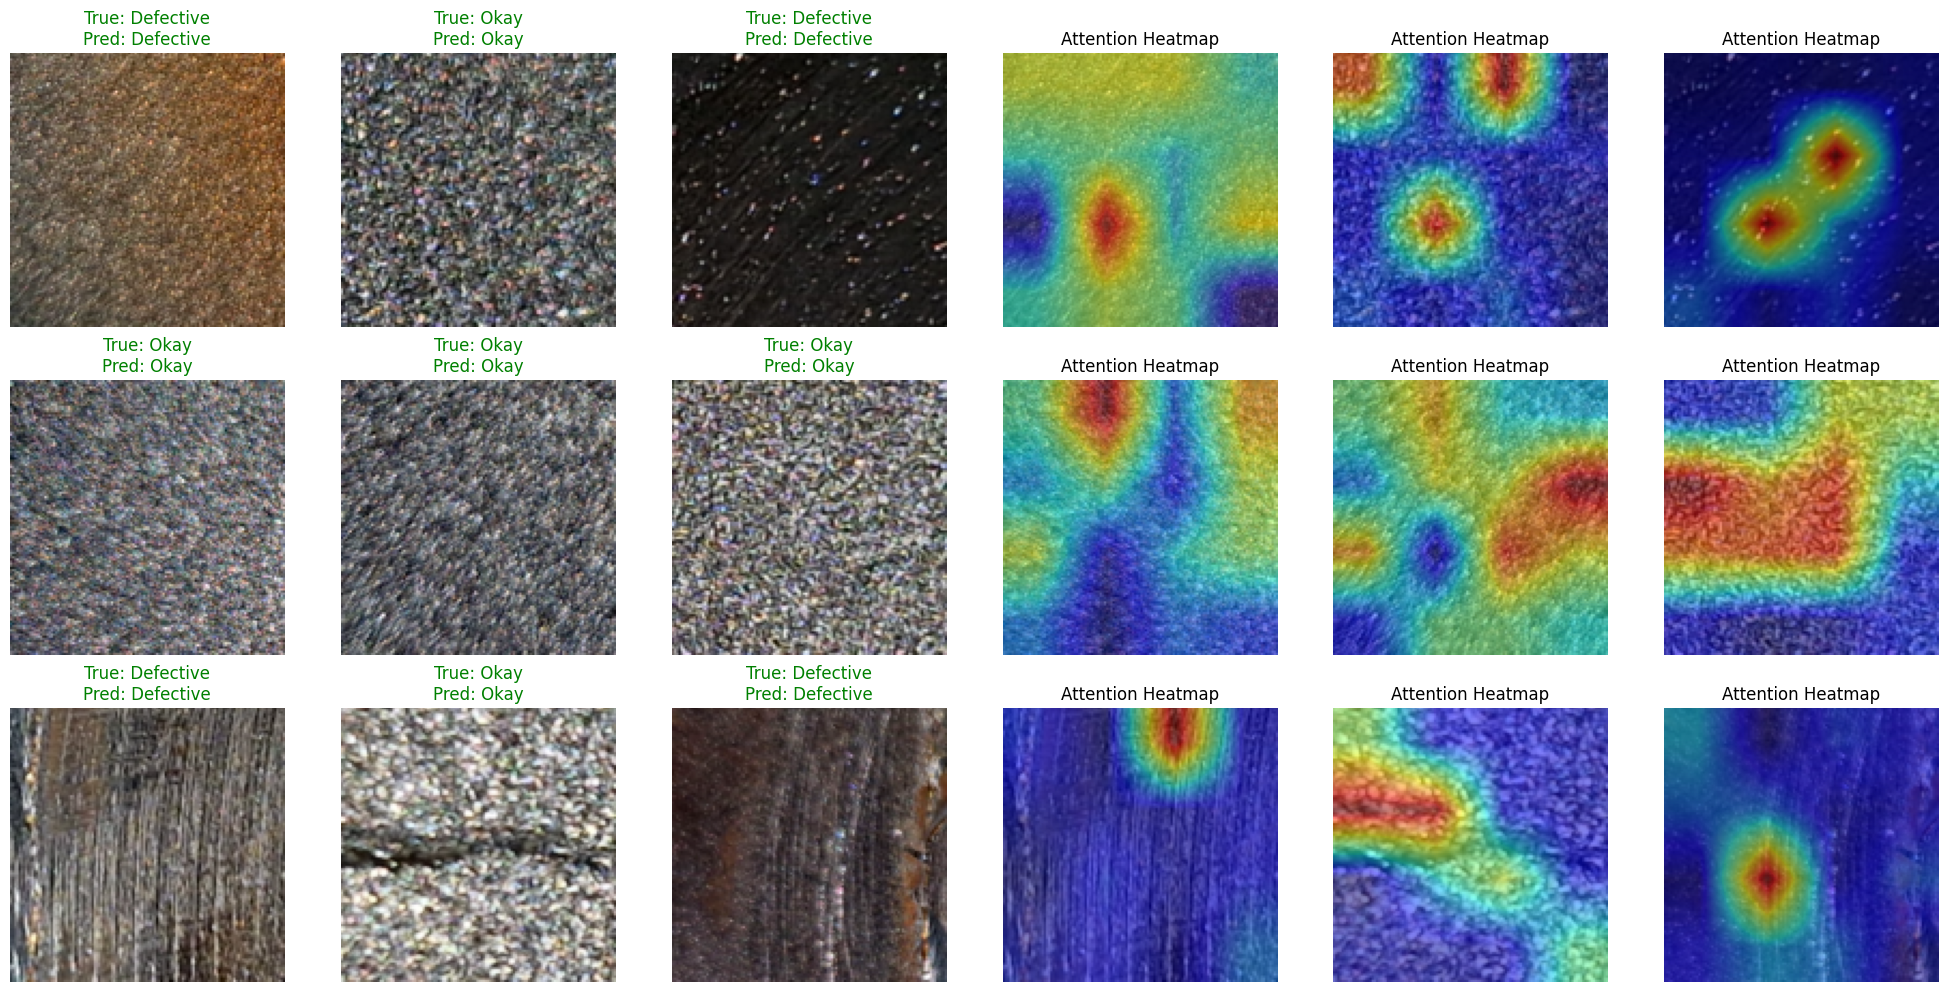

In [ ]:
def visualize_predictions_with_heatmaps(model, dataloader, class_names, image_size, patch_size):
    model.eval()

    images, labels = next(iter(dataloader))
    indices = random.sample(range(len(images)), 9)
    selected_images = images[indices]
    selected_labels = labels[indices]
    predictions = model(selected_images).argmax(dim=1)

    recorder = Recorder(model)

    fig, axes = plt.subplots(3, 6, figsize=(20, 10))
    for i, ax_pair in enumerate(zip(axes[:, :3].flat, axes[:, 3:].flat)):
        pred_ax, heatmap_ax = ax_pair

        img = selected_images[i]
        true_label = selected_labels[i].item()
        pred_label = predictions[i].item()
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        border_color = "green" if true_label == pred_label else "red"

        pred_ax.imshow(img_np)
        pred_ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color=border_color)
        pred_ax.axis("off")
        for spine in pred_ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(4)

        img_input = img.unsqueeze(0) 
        preds, attns = recorder(img_input)  
        last_layer = attns.sum(axis=0).sum(axis=0).sum(axis=0)
        attn_heatmap = last_layer[0, 1:].reshape((int(image_size / patch_size), int(image_size / patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode="bilinear")
        attn_image = attn_heatmap_resized[0][0].detach().numpy()

        heatmap_ax.imshow(img_np)
        heatmap_ax.imshow(attn_image, cmap="jet", alpha=0.5)
        heatmap_ax.axis("off")
        heatmap_ax.set_title("Attention Heatmap")

    plt.tight_layout()
    plt.show()

class_names = ["Okay", "Defective"]

visualize_predictions_with_heatmaps(model, dl_test, class_names, image_size, patch_size)